# Task 1 : Set up colab gpu runtime environment

In [41]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-1gak0iun
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-1gak0iun
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [42]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


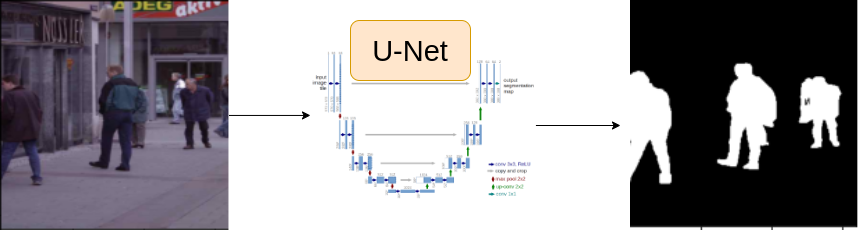

# Some Common Imports

In [43]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [44]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [45]:
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='/content/'
DEVICE='cuda'
EPOCHS=25
LR=0.003
IMAGE_SIZE=320
ENCODER='timm-efficientnet-b0'
WEIGHTS='imagenet'
BATCH_SIZE=16

In [46]:
df=pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [47]:
row=df.iloc[6]
image_path=row.images
mask_path=row.masks
image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)

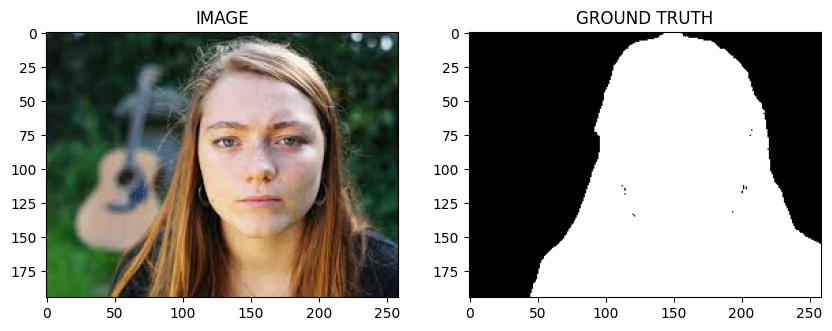

In [48]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [49]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [50]:
import albumentations as A

In [51]:
def get_train_args():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)

  ], is_check_shapes=False)
def get_valid_args():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE)
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [52]:
from torch.utils.data import Dataset

In [53]:
class segmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations
  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    row=self.df.iloc[idx]

    image_path=row.images
    mask_path=row.masks
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) #h,w
    mask=np.expand_dims(mask,axis=-1) #h,w,c

    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)
      image=data['image']
      mask=data['mask']
    #(h,w,c)->(c,h,w)
    image=np.transpose(image,(2,0,1)).astype(np.float32)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)
    image=torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)

    return image,mask


In [54]:
trainset=segmentationDataset(train_df,get_train_args())
validset=segmentationDataset(valid_df,get_valid_args())

In [55]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


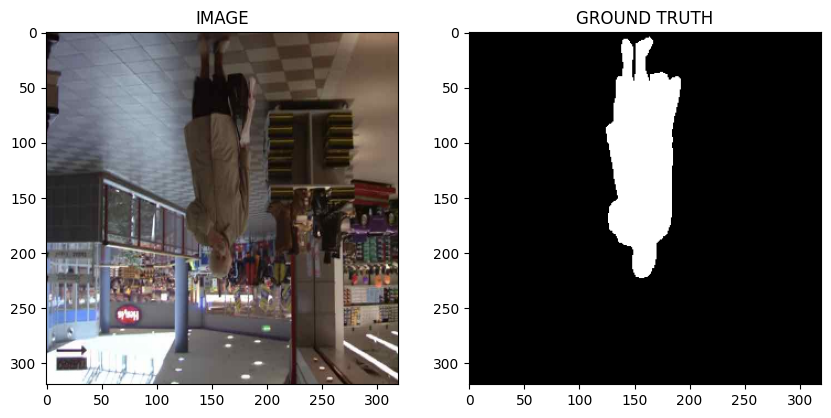

In [56]:
idx=8
image,mask=trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [57]:
from torch.utils.data import DataLoader

In [58]:
trainloader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(validset,batch_size=BATCH_SIZE,shuffle=True)

In [59]:
print(f'Total number of batches in trainloader: {len(trainloader)}')
print(f'Total number of batches in validloader: {len(validloader)}')


Total number of batches in trainloader: 15
Total number of batches in validloader: 4


In [60]:
for image,mask in trainloader:
  break
print(f'one batch image size: {image.shape}')
print(f'one batch mask size: {mask.shape}')

one batch image size: torch.Size([16, 3, 320, 320])
one batch mask size: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [61]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [62]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()
    self.arc=smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )
  def forward(self,images,masks=None):
    logits= self.arc(images)
    if masks !=None:
      loss1= DiceLoss(mode='binary')(logits,masks)
      loss2= nn.BCEWithLogitsLoss()(logits,masks)
      return logits,loss1+loss2
    return logits

In [63]:
model=SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoi

# Task 7 : Create Train and Validation Function

In [64]:
def train_fn(model,data_Loader,optimizer):
  model.train()
  total_loss=0.0

  for image,masks in data_Loader:
    image=image.to(DEVICE)
    masks= masks.to(DEVICE)
    optimizer.zero_grad()
    logits,loss=model(image,masks)
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()
  return total_loss/len(data_Loader)

In [65]:
def eval_fn(model,data_Loader):
  model.eval()
  total_loss=0.0
  with torch.no_grad():
    for image,masks in data_Loader:
      image=image.to(DEVICE)
      masks=masks.to(DEVICE)
      logits,loss=model(image,masks)
      total_loss+=loss.item()
  return total_loss/len(data_Loader)

# Task 8 : Train Model

In [66]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)


In [67]:
best_valid_loss=np.inf

for epoch in range(EPOCHS):
  train_loss=train_fn(model,trainloader,optimizer)
  valid_loss=eval_fn(model,validloader)

  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print('saved model')
    best_valid_loss=valid_loss
  print(f'epoch: {epoch+1} Train loss: {train_loss} Valid loss: {valid_loss}')

saved model
epoch: 1 Train loss: 0.7025595386823018 Valid loss: 1.7412331700325012
saved model
epoch: 2 Train loss: 0.36674917936325074 Valid loss: 0.5706886872649193
saved model
epoch: 3 Train loss: 0.3103033274412155 Valid loss: 0.2075013853609562
epoch: 4 Train loss: 0.26262435913085935 Valid loss: 0.22871749848127365
epoch: 5 Train loss: 0.24550006687641143 Valid loss: 0.24799278378486633
epoch: 6 Train loss: 0.2065753291050593 Valid loss: 0.2218419425189495
saved model
epoch: 7 Train loss: 0.1910658895969391 Valid loss: 0.19706310331821442
epoch: 8 Train loss: 0.17143718004226685 Valid loss: 0.2158793844282627
epoch: 9 Train loss: 0.23470601936181387 Valid loss: 0.24174759536981583
epoch: 10 Train loss: 0.18945959905783336 Valid loss: 0.20921281725168228
epoch: 11 Train loss: 0.19923549890518188 Valid loss: 0.2720223069190979
saved model
epoch: 12 Train loss: 0.19592604438463848 Valid loss: 0.17916806042194366
epoch: 13 Train loss: 0.16074523131052654 Valid loss: 0.185441315174102

# Task 9 : Inference

In [70]:
idx=1
model.load_state_dict(torch.load('/content/best_model.pt'))
image,mask=validset[idx]
logits_mask=model(image.to(DEVICE).unsqueeze(0))#(c,h,w)->(1,c,h,w)
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)

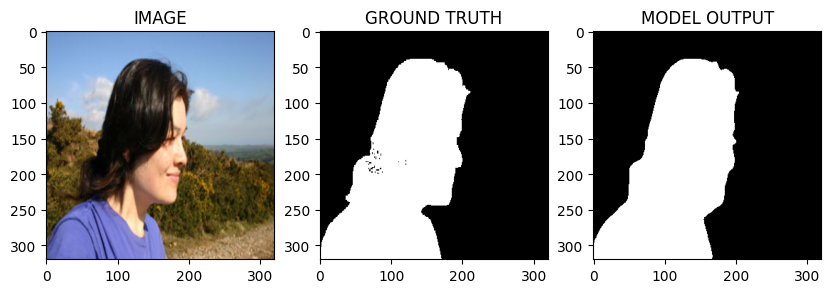

In [71]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya